# Loading and correcting data for RhFe 
# P22 beamtime  in November 2018

In [91]:
%load_ext autoreload
%autoreload 2
%gui tk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
#Imports
# Embedded imports
import os, sys
import math
import matplotlib.pyplot as plt
# Third party imports
import numpy as np
import pandas as pd
import scipy as sp
# Temporary solution for local imports
sys.path.append('..')
from xpstool import helpers 
from xpstool import Experiment, Spectrum, Region
#from xpstool import Fitter

In [86]:
# Constants
p22_energy_3800 = 3800 # Photon energy from the p22 beamline
p22_energy_4600 = 4600 # Photon energy from the p22 beamline
# All fields below are taken from Scienta.txt file except "Conditions",
# which is added manually upon data processing
min_info = [
    "Region Name",
    "Pass Energy",
    "Number of Sweeps",
    "Energy Step",
    "Date",
    "Time",
    "File",
    "Conditions"
]

In [95]:
# ---SCIENTA DATA FOLDERS---
# Full path to data files
data_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/Data"
# Full path to output files
output_folder = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Beamtime/ProcessedData"

file_names = []
file_idx = 0
for file in sorted(os.listdir(data_folder)):
    if file.endswith(".txt"):                         
        file_names.append(file)
        #print(f"---> file[{file_idx}]: {file}")
        file_idx += 1

**Files from 0000 to 0157 were measured at 4600 eV photon energy**

**File 0158 was measured at 3700 eV photon energy (IGNORE)**

**Files from 0159 to 0347 were measured at 3800 eV photon energy**

## <font color ='blue'>First experiment H2 : CO2 = 1 : 1 at ~50 mbar</font>

### Overview

In [108]:
# Complete list of files within the experimet
# All three lists below must have the same length
fermi_nums = [
    "0002",
    "0014",
    "0019",
    "0024",
    "0029",
    "0034",
    "0039",
    "0044",
]
# Order: C1s, O1s, Fe2p, Rh3d
scan_sets = [
    ["0004", "0003", "0005", "0007"],
    ["0011", "0008", "0013", "0012"],
    ["0016", "0015", "0018", "0017"],
    ["0021", "0020", "0023", "0022"],
    ["0025", "0026", "0028", "0027"],
    ["0031", "0030", "0033", "0032"],
    ["0036", "0035", "0038", "0037"],
    ["0041", "0040", "0043", "0042"]
]
conditions = [
    {"Temperature": "25 C"},
    {"Temperature": "150 C"},
    {"Temperature": "200 C"},
    {"Temperature": "250 C"},
    {"Temperature": "300 C"},
    {"Temperature": "350 C"},
    {"Temperature": "400 C"},
    {"Temperature": "450 C"}
]

# Create an Experiment object to store spectra specified above
exp = Experiment()

# Uploading Fermi regions. Checking that the corresponding spectra 
# contain exactly one region and setting FermiFlags for this region.
for i, num in enumerate(fermi_nums):
    spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]))
    if spectrum.isEmpty():
        print(f"{spectrum.getID()} spectrum: 0 regions")
    else:
        spectrum.setConditions(conditions[i])
        if len(spectrum.getRegions() == 1):
            spectrum.getRegion().setFermiFlag()
        else:
             print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions()} regions")
        exp.addSpectrum(num, spectrum)

# Uploading other regions. Checking that the corresponding spectra 
# contain exactly one region.
for i, subset in enumerate(scan_sets):    
    for numstr in subset:
        spectrum = Spectrum(path="/".join([data_folder, f"{num}.txt"]))
        if spectrum.isEmpty():
            print(f"{spectrum.getID()} spectrum: 0 regions")
        else:
            spectrum.setConditions(conditions[i])
            exp.addSpectrum(num, spectrum)
            if len(spectrum.getRegions() > 1):
                print(f"{spectrum.getID()} spectrum: {len(spectrum.getRegions()} regions")

[autoreload of xpstool failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../xpstool/__init__.py", line 1, in <module>
    from .datahandler import Experiment, Spectrum, AddDimensionSpectrum, Region
ImportError: cannot import name 'Experiment'
]


SyntaxError: f-string: expecting '}' (<ipython-input-108-fea65406ec76>, line 49)

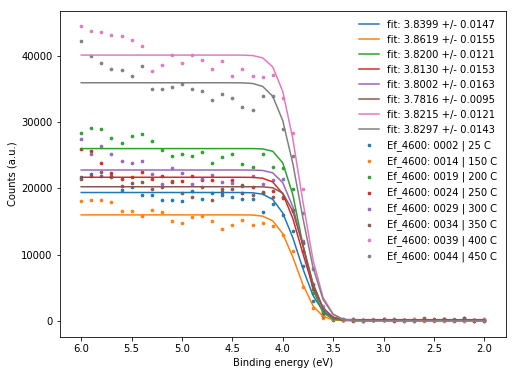

In [7]:
# Adjusting and plotting Fermi regions
shifts = []
fig = plt.figure(1, figsize=(8,6))
for fermi in fermi_levels:
    fermi.setFermiFlag()
    fermi.invertToBinding(p22_energy_4600)
    fermi.plotRegion(1, scatter=True, title=False)

    fit_parameters = [1, 3.8, 0.2, 20000]
    #Fitting and adding a column with the fit function to the region object
    fit_res = helpers.fitFermiEdge(fermi, fit_parameters, add_column=True)
    shift = fit_res[0][1]
    error = fit_res[2][1]
    shifts.append([shift, error])
    fermi.plotRegion(fig.number, y_data="fitfermi", label=f"fit: {shift:.4f} +/- {error:.4f}", title=False)

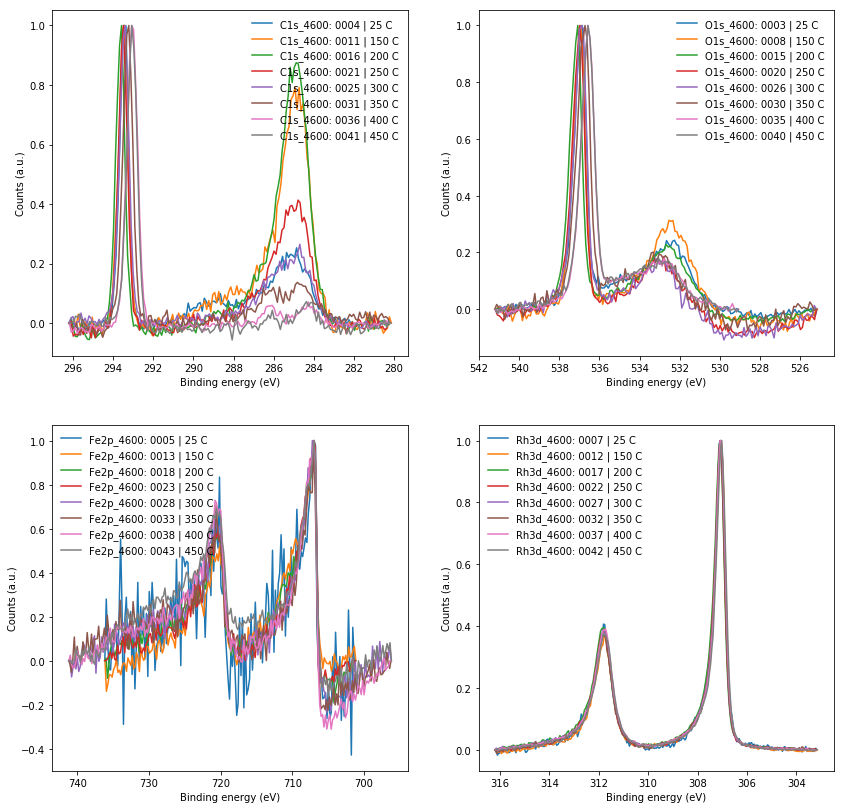

In [8]:
# Adjusting and plotting data overview
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
ax = [ax1, ax2, ax3, ax4]
### Misbehaving regions handpicked treatment
all_scans[6][1].cropRegion(stop=121)
all_scans[7][1].cropRegion(stop=121)
###
for i, single_set in enumerate(all_scans): 
    for j, scan in enumerate(single_set):
        scan.correctEnergyShift(shifts[i][0])
        scan.invertToBinding(p22_energy_4600)
        # Subtract Shirley or linear background
        #l_background = helpers.calculateLinearBackground(scan, add_column=True)
        s_background = helpers.calculateShirley(scan, add_column=True)
        normalized = helpers.normalize(scan, y_data="shirley corrected", add_column=True)
        # Plotting spectra with Shirley background subtracted
        scan.plotRegion(figure=fig.number, ax=ax[j], y_data="normalized", title=False)

### Experiment step by step

Start with the following flows <br>
<font color ='red'>CO2 -> 0.3 L/m <br>
H2 -> 0.3 L/m <br>
He -> 0.16 L/m <br></font>

#### 1. Room temperature <br>
First diff pumping stage pressure 5.6e-4 <br>
Files: <br>
>    Ef_4600 - 0002.txt <br>
    O1s_4600 - 0003.txt <br>
    C1s_4600 - 0004.txt <br>
    Fe2p_4600 - 0005.txt <br>
    Rh3d_4600 - 0007.txt <br>

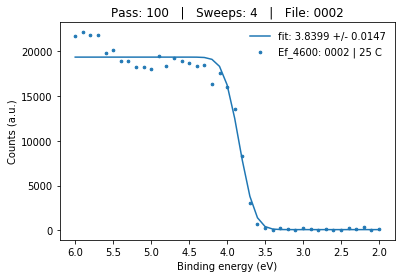

In [9]:
#Experiment #1
exp = 0
fermi_levels[exp].plotRegion(1, scatter=True)
fermi_levels[exp].plotRegion(1, y_data="fitfermi", label=f"fit: {shifts[exp][0]:.4f} +/- {shifts[exp][1]:.4f}")

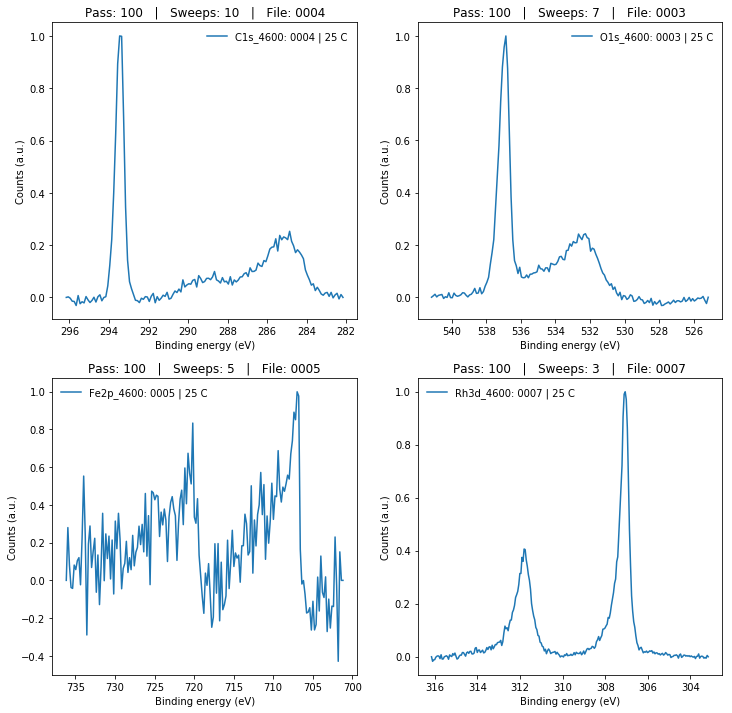

In [10]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax = [ax1, ax2, ax3, ax4]
for i, scan in enumerate(all_scans[exp]):
    # Subtract Shirley background 
    #background = helpers.calculateShirley(scan, add_column=True)
    # Plotting spectra with Shirley background subtracted
    scan.plotRegion(figure=fig.number, ax=ax[i], y_data="normalized")
    

[array([-2.22767181e-01,  3.07066145e+02, -1.13945849e-01,  2.40772119e-01,
        3.07366999e+02,  3.49040268e-01]), array([[ 3.99387958e-05, -1.12962605e-06,  1.12797214e-05,
         4.05436416e-05, -8.65750183e-05, -1.03462088e-05],
       [-1.12962605e-06,  5.41362080e-06, -3.19529020e-07,
         2.33456098e-07, -4.34741500e-06,  8.70284362e-06],
       [ 1.12797214e-05, -3.19529020e-07,  4.49674952e-06,
         1.14493624e-05, -2.27619680e-05, -2.38543480e-06],
       [ 4.05436416e-05,  2.33456098e-07,  1.14493624e-05,
         5.82744782e-05, -8.96304328e-05,  7.85446404e-06],
       [-8.65750183e-05, -4.34741500e-06, -2.27619680e-05,
        -8.96304328e-05,  2.92371148e-04,  1.24984913e-05],
       [-1.03462088e-05,  8.70284362e-06, -2.38543480e-06,
         7.85446404e-06,  1.24984913e-05,  6.30168386e-05]]), array([0.00631971, 0.00232672, 0.00212055, 0.00763377, 0.01709886,
       0.00793831])]


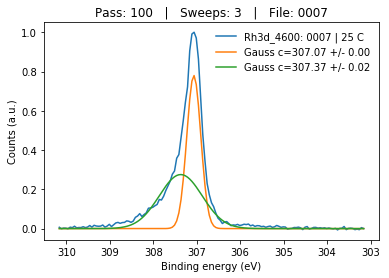

In [24]:
scan = all_scans[exp][3]
scan.cropRegion(start=120)
fit_parameters = [1, 307, 2, 0.1, 308, 0.1]
fit_res = helpers.fitSingleGaussian(scan, fit_parameters, y_data='normalized', add_column=True)
print(fit_res)
scan.plotRegion(y_data="normalized")
scan.plotRegion(y_data="onegauss", label=f"Gauss c={fit_res[0][1]:.2f} +/- {fit_res[2][1]:.2f}")
scan.plotRegion(y_data="twogauss", label=f"Gauss c={fit_res[0][4]:.2f} +/- {fit_res[2][4]:.2f}")

#### 2. 150 C <br>
CO2 -> 0.3 L/m <br>
H2 -> 0.3 L/m <br>
He -> 0.16 L/m <br>
First diff pumping stage pressure 3.3e-4 <br>
Files: <br>
>    Ef_4600 - 0014.txt <br>
    O1s_4600 - 0008.txt <br>
    C1s_4600 - 0011.txt <br>
    Fe2p_4600 - 0013.txt <br>
    Rh3d_4600 - 0012.txt <br>